# Horse colic
## Project goal
The goal of the project is to train and build a horse colic complication model based on [Horse Colic Data Set](https://archive.ics.uci.edu/ml/datasets/Horse+Colic).
The task is a multiclass classification problem and outcome model should predict whether a colic horse will die, survive or be euthanized.

## Data acquisition, analysis and pre-processing
### Data downloading
Dataset is split into 3 parts:
- file *horse-colic.data* with training data - 300 records
- file *horse-colic.test* with test data - 68 records
- file *horse-colic.names* with dataset description and column names

Data is downloaded programmatically and saved into data subfolder of current working directory. However, *horse-colic.names* need to be parsed before pandas can use it as column names definition. Cell below does this task. Parsed column names are saved into *horse-colic.names.parsed* file.

In [1]:
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/horse-colic'
TRAIN_DATA_FILE_NAME = 'horse-colic.data'
TEST_DATA_FILE_NAME = 'horse-colic.test'
NAMES_FILE_NAME = 'horse-colic.names'
DATA_DIRECTORY_PATH = './data'
COLUMN_NAMES = []

import os
import re
import requests

#function downloads 3 files and saves it in given path. function also creates 4th file which contains parsed dataframe-ready column names
def download_data(url=URL, train_file_name=TRAIN_DATA_FILE_NAME, test_file_name=TEST_DATA_FILE_NAME,
                  names_file_name=NAMES_FILE_NAME, path=DATA_DIRECTORY_PATH):
    try:
        os.mkdir(path)
    except FileExistsError:
        print(f"Directory {path} already exists")
    for filename in [train_file_name, test_file_name, names_file_name]:
        download_save_file(url, filename, path=path)
    parse_names(names_file_name, f"{names_file_name}.parsed")

#function downloads single file and saves it in given path
def download_save_file(url, filename, path=DATA_DIRECTORY_PATH):
    content = requests.get(f"{url}/{filename}").content
    with open(f"{path}/{filename}", 'w') as f:
        f.write(bytes.decode(content, 'utf-8').replace(' \n', '\n')) #trailing space at the line endings leads to problems

#function extracts column names from names file (file also contains column descriptions)
def parse_names(filename_in, filename_out, path=DATA_DIRECTORY_PATH):
    pattern = '^\d+:\s*' #columns are generally listed like '{id}:'
    names = []
    with open(f"{path}/{filename_in}") as f:
        for line in [line.strip() for line in f.readlines()]:
            if re.match(pattern, line):
                names.append(re.sub(pattern, '', line))
    last_name = names.pop()
    names.extend(['lesion type 1', 'lesion type 2', 'lesion type 3']) #some columns are listed in different way
    names.append(last_name)
    names[names.index("pain - a subjective judgement of the horse's pain level")] = "pain" #this column name is not parsed correctly
    with open(f"{path}/{filename_out}", "w") as f:
        f.write(','.join(names))
    COLUMN_NAMES.extend(names) #save it in variable for later usage

download_data()

Directory ./data already exists


### Data analysis
#### Missing values
Many fields with null values - according to description its about 30% of missing values. There are only 7 columns out of 28 with value in every row! Moreover, there are only 6 rows out of 300 in values in every col! Fixing those missing values will be quite challenging.
Rows with missing values in outcome column should be definitely dropped, because outcome is the value that we predict.

In [2]:
import pandas as pd

#prevent information lose with dtype - lesions are encoded with 0s at beginning
dtype = {'lesion type 1': str, 'lesion type 2': str, 'lesion type 3': str }

horse_colic_train = pd.read_csv("./data/horse-colic.data", sep=' ', na_values='?', header=None, names=COLUMN_NAMES, dtype=dtype)
horse_colic_test = pd.read_csv("./data/horse-colic.test", sep=' ', na_values='?', header=None, names=COLUMN_NAMES, dtype=dtype)
horse_colic_train.info() #columns without nulls counted manually
print(f"not null rows count: {horse_colic_train[horse_colic_train.notnull().all(1)].shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   surgery?                     299 non-null    float64
 1   Age                          300 non-null    int64  
 2   Hospital Number              300 non-null    int64  
 3   rectal temperature           240 non-null    float64
 4   pulse                        276 non-null    float64
 5   respiratory rate             242 non-null    float64
 6   temperature of extremities   244 non-null    float64
 7   peripheral pulse             231 non-null    float64
 8   mucous membranes             253 non-null    float64
 9   capillary refill time        268 non-null    float64
 10  pain                         245 non-null    float64
 11  peristalsis                  256 non-null    float64
 12  abdominal distension         244 non-null    float64
 13  nasogastric tube    

#### Column types
All 27 columns are numerical. That's true only because all categorical columns are encoded. We will of course need to deal with it.
Continuous variables are fine as they are (for now let's omit data scaling etc.)
Categorical variables with ordinal scale will stay encoded as numbers, however some modifications may be required e.g. when encoding does not represent natural order well.
Categorical variables with nominal scale will be decoded back to strings. These variables will be dummy encoded in next steps so using string is better approach - readability will be improved.

In [3]:
#it can be binary encoded with '0' and '1'
horse_colic_train['surgery?'].value_counts()

1.0    180
2.0    119
Name: surgery?, dtype: int64

In [4]:
#2 possible age values - according to description '1' for adult horse (>6 month) and '2' for young horse (<6 months)
#however current column values are different. we assume that '9' means that horse is young
#it's also better to rename this column to 'adult?' and encode it binary
horse_colic_train['Age'].value_counts()

1    276
9     24
Name: Age, dtype: int64

In [5]:
#this column indicates horse unique identifier, some rows are repeated because single horse may have more than one row in dataset
#this column could be useful for creating an interesting time series but there is not enough data, so we will probably delete it.
horse_colic_train['Hospital Number']

0       530101
1       534817
2       530334
3      5290409
4       530255
        ...   
295     533886
296     527702
297     529386
298     530612
299     534618
Name: Hospital Number, Length: 300, dtype: int64

In [6]:
#next 3 columns (rectal temperature, pulse, respiratory rate) are continuous. They will probably be very relevant because they determine horse base vital signs.
#pulse and respiratory rate have max value much bigger than 3rd quartile but as we see these are not single cases, so we don't treat it as outliers
print(horse_colic_train.iloc[:, 3:6].describe())
print(horse_colic_train['pulse'].sort_values(ascending=False).head())
print(horse_colic_train['respiratory rate'].sort_values(ascending=False).head())

       rectal temperature       pulse  respiratory rate
count          240.000000  276.000000        242.000000
mean            38.167917   71.913043         30.417355
std              0.732289   28.630557         17.642231
min             35.400000   30.000000          8.000000
25%             37.800000   48.000000         18.500000
50%             38.200000   64.000000         24.500000
75%             38.500000   88.000000         36.000000
max             40.800000  184.000000         96.000000
255    184.0
3      164.0
55     160.0
275    150.0
41     150.0
Name: pulse, dtype: float64
39     96.0
106    96.0
269    90.0
186    90.0
244    88.0
Name: respiratory rate, dtype: float64


In [7]:
#this column is in ordinal scale, so we will keep it encoded. however we will need to change encoding because
#current one doesn't represent natural order (1 = Normal, 2 = Warm, 3 = Cool, 4 = Cold)
#in case of regression model we will probably delete this column because it's strongly correlated with rectal temperature
horse_colic_train['temperature of extremities'].value_counts()

3.0    109
1.0     78
2.0     30
4.0     27
Name: temperature of extremities, dtype: int64

In [8]:
#this column encoding should be also fixed, because for now it doesn't represent natural order (1 = normal, 2 = increased, 3 = reduced, 4 = absent)
#we will consider removing this column because it's values are missing in 69 rows and it's very subjective
horse_colic_train['peripheral pulse'].value_counts()

1.0    115
3.0    103
4.0      8
2.0      5
Name: peripheral pulse, dtype: int64

In [9]:
#this column ordering is also wrong, but this time we only need to swap '5' with '6'
#encoding meaning - 1 = normal pink, 2 = bright pink, 3 = pale pink, 4 = pale cyanotic, 5 = bright red / injected, 6 = dark cyanotic
#dataset description specifies 4 groups for these 6 values, so we would be able to reduce value count, however we will not do it
#because we could lose some information and value count is not critical (ordinal scale = not dummies = no extra dimensions)
horse_colic_train['mucous membranes'].value_counts()

1.0    79
3.0    58
4.0    41
2.0    30
5.0    25
6.0    20
Name: mucous membranes, dtype: int64

In [10]:
#this column can be encoded binary. according to dataset description there are only 2 possible values - '1' (< 3 seconds) and '2' (>= 3 seconds), so we have to delete values from rows with '3' (meaningless)
#The Capillary refill test (CRT) is a rapid test used for assessing the blood flow through peripheral tissues.
print(horse_colic_train['capillary refill time'].value_counts())

horse_colic_train.loc[horse_colic_train['capillary refill time'] == 3, 'capillary refill time'] = None
print(horse_colic_train['capillary refill time'].value_counts())

1.0    188
2.0     78
3.0      2
Name: capillary refill time, dtype: int64
1.0    188
2.0     78
Name: capillary refill time, dtype: int64


In [11]:
#this column data is in ordinal scale but according to dataset description we should not treat this column as an ordered variable.
# we will use dummy variables but before that we will decode it back to text representation (improved readability)
horse_colic_train['pain'].value_counts()

3.0    67
2.0    59
5.0    42
4.0    39
1.0    38
Name: pain, dtype: int64

In [12]:
#Peristalsis is the automatic wave-like movement of the muscles that line gastrointestinal tract.
#this column will be treated like a nominal variable because it's values meaning is not clear
horse_colic_train['peristalsis'].value_counts()

3.0    128
4.0     73
1.0     39
2.0     16
Name: peristalsis, dtype: int64

In [13]:
#this column is an ordinal variable and finally its encoded correctly (1 = none, 2 = slight, 3 = moderate, 4 = severe) - however we could subtract one from each value to start encoding from 0
#moreover this variable is marked as an IMPORTANT parameter in dataset description
horse_colic_train['abdominal distension'].value_counts()

1.0    76
2.0    65
3.0    65
4.0    38
Name: abdominal distension, dtype: int64

In [14]:
#according to dataset description this column refers to any gas coming out of the tube
#encoding is correct with a good order (1 = none, 2 = slight, 3 = significant)
horse_colic_train['nasogastric tube'].value_counts()

2.0    102
1.0     71
3.0     23
Name: nasogastric tube, dtype: int64

In [15]:
#encoding order is not correct (1 = none, 2 = > 1 liter, 3 = < 1 liter)
horse_colic_train['nasogastric reflux'].value_counts()

1.0    120
3.0     39
2.0     35
Name: nasogastric reflux, dtype: int64

In [16]:
#this column has values in only 53 rows! we will probably delete it
horse_colic_train['nasogastric reflux PH'].describe()

count    53.000000
mean      4.707547
std       1.982311
min       1.000000
25%       3.000000
50%       5.000000
75%       6.500000
max       7.500000
Name: nasogastric reflux PH, dtype: float64

In [17]:
#these columns will be encoded with dummy variables
print(horse_colic_train['rectal examination - feces'].value_counts())
print(horse_colic_train['abdomen'].value_counts())

4.0    79
1.0    57
3.0    49
2.0    13
Name: rectal examination - feces, dtype: int64
5.0    79
4.0    43
1.0    28
2.0    19
3.0    13
Name: abdomen, dtype: int64


In [18]:
#this column is a continuous variable, values look good - probably no outliers
print(horse_colic_train['packed cell volume'].describe())
print(horse_colic_train['packed cell volume'].sort_values(ascending=False).head())

count    271.000000
mean      46.295203
std       10.419335
min       23.000000
25%       38.000000
50%       45.000000
75%       52.000000
max       75.000000
Name: packed cell volume, dtype: float64
144    75.0
151    75.0
4      74.0
49     73.0
35     73.0
Name: packed cell volume, dtype: float64


In [18]:
#this column is a continuous variable, values also look good - probably no outliers
print(horse_colic_train['total protein'].describe())
print(horse_colic_train['total protein'].sort_values(ascending=False).head())

count    267.000000
mean      24.456929
std       27.475009
min        3.300000
25%        6.500000
50%        7.500000
75%       57.000000
max       89.000000
Name: total protein, dtype: float64
208    89.0
90     86.0
1      85.0
63     82.0
14     81.0
Name: total protein, dtype: float64


In [19]:
#we will remove these columns because they have many missing values
print(horse_colic_train['abdominocentesis appearance'].value_counts())
print(horse_colic_train['abdomcentesis total protein'].describe())

2.0    48
3.0    46
1.0    41
Name: abdominocentesis appearance, dtype: int64
count    102.000000
mean       3.019608
std        1.968567
min        0.100000
25%        2.000000
50%        2.250000
75%        3.900000
max       10.100000
Name: abdomcentesis total protein, dtype: float64


In [21]:
#we want to predict the value of this column - its missing in one row in training set so this row will be removed
#we will also decode it back to string representation (1 = lived, 2 = died, 3 = was euthanized)
horse_colic_train['outcome'].value_counts()

1.0    178
2.0     77
3.0     44
Name: outcome, dtype: int64

In [22]:
#this column indicates whether the horse had a lesion. it will be removed because we will be more interested in total number of lesion - see below
print(horse_colic_train['surgical lesion?'].value_counts())

1    191
2    109
Name: surgical lesion?, dtype: int64


In [23]:
#3 next columns indicates horse's lesions. there are max 3 lesions listed in dataset but horse can have 0, 1, 2 or 3 lesions. statistics are computed and showed below
_lesions = horse_colic_train.loc[:, ['lesion type 1', 'lesion type 2', 'lesion type 3']]
_lesions_counts = [
    _lesions[_lesions.iloc[:, 0] == '00000'].count()[0],
    _lesions[(_lesions.iloc[:,0] != '00000') & (_lesions.iloc[:,1] == '00000')].count()[0],
    _lesions[(_lesions.iloc[:,0] != '00000') & (_lesions.iloc[:,1] != '00000') & (_lesions.iloc[:,2] == '00000')].count()[0],
    _lesions[(_lesions.iloc[:,0] != '00000') & (_lesions.iloc[:,1] != '00000') & (_lesions.iloc[:,2] != '00000')].count()[0]
]

for i, count in zip(range(4), _lesions_counts):\
    print(f"{count} horse(s) with {i} lesion(s)")
print(f"-------------------------\ntotal={sum(_lesions_counts)}")

56 horse(s) with 0 lesion(s)
237 horse(s) with 1 lesion(s)
6 horse(s) with 2 lesion(s)
1 horse(s) with 3 lesion(s)
-------------------------
total=300


In [24]:
#moreover each lesion is composed of 4 parts: site of lesion (11 possible values),
#lesion type (4 possible values), lesion subtype (3 possible values) and "lesion specific code" (11 possible values).
#this in total gives (11 + 4 + 3 + 11) * 3 = 87 dummy variables!
#its definitely too much so our approach will use only one lesion (the recent one) details and total number of lesions.
_lesions.head()

,lesion type 1,lesion type 2,lesion type 3
0,11300,00000,00000
1,02208,00000,00000
2,00000,00000,00000
3,02208,00000,00000
4,04300,00000,00000


In [25]:
#lesion parts are encoded with positional numbers but its length is not fixed. 1st part is can have 1 or 2 digits (range from 00 to 11), 2nd and 3rd are fixed to 1 digit, 4th part can have 1 or 2 digits (range from 0 to 10).
#As we see we practically always have 5 digits. In this case if 2 first digits are in 1t part range then we will
#always interpret them as 1st part. Else we will interpret 2 last digits as a 4th part.
print(_lesions['lesion type 1'].apply(lambda x: len(x)).value_counts())
print(_lesions['lesion type 2'].apply(lambda x: len(x)).value_counts())
print(_lesions['lesion type 3'].apply(lambda x: len(x)).value_counts())

5    300
Name: lesion type 1, dtype: int64
5    300
Name: lesion type 2, dtype: int64
5    299
6      1
Name: lesion type 3, dtype: int64


In [26]:
#meaning of this column is not clear, so it will be deleted
horse_colic_train['cp_data'].value_counts()

2    201
1     99
Name: cp_data, dtype: int64

#### Test set quick inspection
Now we will look at test set. We will check if every column with no NA values in train set is also filled in test set. If not and we don't handle this now it could lead to problems in model evaluation. We won't touch test set! If its true we will adjust our pipe in next section.

In [27]:
horse_colic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   surgery?                     67 non-null     float64
 1   Age                          68 non-null     int64  
 2   Hospital Number              68 non-null     int64  
 3   rectal temperature           59 non-null     float64
 4   pulse                        66 non-null     float64
 5   respiratory rate             55 non-null     float64
 6   temperature of extremities   59 non-null     float64
 7   peripheral pulse             54 non-null     float64
 8   mucous membranes             67 non-null     float64
 9   capillary refill time        62 non-null     float64
 10  pain                         60 non-null     float64
 11  peristalsis                  60 non-null     float64
 12  abdominal distension         59 non-null     float64
 13  nasogastric tube      

In [28]:
#we had invalid value in this column in train set but in test set its fine
horse_colic_test['capillary refill time'].value_counts()

1.0    44
2.0    18
Name: capillary refill time, dtype: int64

In [29]:
#columns with na in test AND columns with NOT na in train (we don't care about opposite direction)
horse_colic_test.isna().any() & ~horse_colic_train.isna().any()
#all columns with False so our test set if fine

surgery?                       False
Age                            False
Hospital Number                False
rectal temperature             False
pulse                          False
respiratory rate               False
temperature of extremities     False
peripheral pulse               False
mucous membranes               False
capillary refill time          False
pain                           False
peristalsis                    False
abdominal distension           False
nasogastric tube               False
nasogastric reflux             False
nasogastric reflux PH          False
rectal examination - feces     False
abdomen                        False
packed cell volume             False
total protein                  False
abdominocentesis appearance    False
abdomcentesis total protein    False
outcome                        False
surgical lesion?               False
lesion type 1                  False
lesion type 2                  False
lesion type 3                  False
c

### Data pre-processing
Now, based on last section, we will prepare our data for machine learning algorithms. We will use sklearn Pipeline so this steps will be reusable (and used for test set in evaluation phase).

#### Column dropping
In this step we will drop columns which were marked to drop during analysis.

In [30]:
#https://stackoverflow.com/questions/68402691/adding-dropping-column-instance-into-a-pipeline
class ColumnDropperTransformer:
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self

columnDropper = ColumnDropperTransformer(['Hospital Number','temperature of extremities',
                                          'peripheral pulse', 'nasogastric reflux PH',
                                          'abdominocentesis appearance', 'abdomcentesis total protein',
                                          'surgical lesion?', 'cp_data'
                                          ])

#We create copy of training set because we don't want to use transformer on training set yet.
#We will later use all transformers on original training set at once with Pipeline.
horse_colic_train_cp = horse_colic_train.copy()
horse_colic_train_cp = columnDropper.transform(horse_colic_train_cp)
horse_colic_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery?                    299 non-null    float64
 1   Age                         300 non-null    int64  
 2   rectal temperature          240 non-null    float64
 3   pulse                       276 non-null    float64
 4   respiratory rate            242 non-null    float64
 5   mucous membranes            253 non-null    float64
 6   capillary refill time       266 non-null    float64
 7   pain                        245 non-null    float64
 8   peristalsis                 256 non-null    float64
 9   abdominal distension        244 non-null    float64
 10  nasogastric tube            196 non-null    float64
 11  nasogastric reflux          194 non-null    float64
 12  rectal examination - feces  198 non-null    float64
 13  abdomen                     182 non

#### Row dropping
In this step we will drop row which is the only row with missing values in 2 particular columns - 'surgery?' and 'outcome'.
By this action we lose only one observation (row) but we fix na values in 2 columns.

In [31]:
class RowDropperTransformer:
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.dropna(subset = self.columns)

    def fit(self, X, y=None):
        return self

rowDropper = RowDropperTransformer(['surgery?', 'outcome'])
horse_colic_train_cp = rowDropper.transform(horse_colic_train_cp)
horse_colic_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   surgery?                    299 non-null    float64
 1   Age                         299 non-null    int64  
 2   rectal temperature          239 non-null    float64
 3   pulse                       275 non-null    float64
 4   respiratory rate            241 non-null    float64
 5   mucous membranes            252 non-null    float64
 6   capillary refill time       265 non-null    float64
 7   pain                        244 non-null    float64
 8   peristalsis                 255 non-null    float64
 9   abdominal distension        243 non-null    float64
 10  nasogastric tube            195 non-null    float64
 11  nasogastric reflux          193 non-null    float64
 12  rectal examination - feces  197 non-null    float64
 13  abdomen                     181 non

#### Filling missing values
In this step we will fit missing values in all columns. We will do it with 3 different ways:
- filling continuous columns with mean,
- filling discrete columns with mode,
- and finally we will fill one important column with KNN estimator.

KNNImputer works only as regressor, so later we will have to convert it's output to discrete variable.
To specify different imputers for individual columns we will use ColumnTransformer. ColumnTransformer changes column names, so we will create CustomColumnTransformer which doesn't.

In [32]:
from sklearn.compose import ColumnTransformer

class CustomColumnTransformer:
    def __init__(self, transformations, remainder="passthrough", names_mapper = lambda x: x):
        self.transformations=transformations
        self.remainder = remainder
        self.names_mapper = names_mapper #it will be useful in later CustomColumnTransformer usage

    def transform(self,X,y=None):
        ct =  ColumnTransformer(self.transformations, remainder=self.remainder).set_output(transform="pandas")
        result = ct.fit_transform(X)
        #Result columns names are determined by "{transformation_name}__{original_column_name}", so we need to delete this first part.
        result.columns = [self.names_mapper(name[name.index('__')+2:]) for name in ct.get_feature_names_out()]
        return result

    def fit(self, X, y=None):
        return self

In [33]:
from sklearn.impute import SimpleImputer, KNNImputer

#these columns will be imputed with a mean
continuousColumns = ['rectal temperature', 'pulse', 'respiratory rate', 'packed cell volume', 'total protein', ]
#these columns will be imputed with a median
discreteColumns = ['mucous membranes', 'capillary refill time', 'pain', 'peristalsis', 'nasogastric tube', 'nasogastric reflux', 'rectal examination - feces', 'abdomen', ]
#this column will be imputed with a KNN because its marked as an important parameter
knnColumns = ['abdominal distension']

fillNaTransformer = CustomColumnTransformer([
    ('fillWithMean', SimpleImputer(strategy='mean'), continuousColumns),
    ('fillWithMedian', SimpleImputer(strategy="most_frequent"), discreteColumns),
    ('fillWithKnn', KNNImputer(n_neighbors=3), knnColumns)
])

horse_colic_train_cp = fillNaTransformer.transform(horse_colic_train_cp)
horse_colic_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   rectal temperature          299 non-null    float64
 1   pulse                       299 non-null    float64
 2   respiratory rate            299 non-null    float64
 3   packed cell volume          299 non-null    float64
 4   total protein               299 non-null    float64
 5   mucous membranes            299 non-null    float64
 6   capillary refill time       299 non-null    float64
 7   pain                        299 non-null    float64
 8   peristalsis                 299 non-null    float64
 9   nasogastric tube            299 non-null    float64
 10  nasogastric reflux          299 non-null    float64
 11  rectal examination - feces  299 non-null    float64
 12  abdomen                     299 non-null    float64
 13  abdominal distension        299 non

In [34]:
horse_colic_train_cp.head()

,rectal temperature,pulse,respiratory rate,packed cell volume,total protein,mucous membranes,capillary refill time,pain,peristalsis,nasogastric tube,nasogastric reflux,rectal examination - feces,abdomen,abdominal distension,surgery?,Age,outcome,lesion type 1,lesion type 2,lesion type 3
0,38.5,66.0,28.0,45.0,8.4,1.0,2.0,5.0,4.0,2.0,1.0,3.0,5.0,4.000000,2.0,1,2.0,11300,00000,00000
1,39.2,88.0,20.0,50.0,85.0,4.0,1.0,3.0,4.0,2.0,1.0,4.0,2.0,2.000000,1.0,1,3.0,02208,00000,00000
2,38.3,40.0,24.0,33.0,6.7,3.0,1.0,3.0,3.0,2.0,1.0,1.0,1.0,1.000000,2.0,1,1.0,00000,00000,00000
3,39.1,164.0,84.0,48.0,7.2,6.0,2.0,2.0,4.0,1.0,2.0,3.0,5.0,4.000000,1.0,9,2.0,02208,00000,00000
4,37.3,104.0,35.0,74.0,7.4,6.0,2.0,3.0,3.0,2.0,1.0,4.0,5.0,2.271605,2.0,1,2.0,04300,00000,00000


#### Fixing discrete encoding
As we agreed during analysis there are some things to do with discrete variables. For ordinal ones we need to fix order in some columns. For nominal ones we agreed that it's better to use their names because later created dummy variables will be more readable.
We will create custom transformer to handle this encoding fixation. Moreover, this transformer will allow to change column name and type.

In [35]:
class DiscreteEncodingTransformer:
    def __init__(self, column, mapping, target_name=None, target_type='uint8'):
        self.column = column
        self.mapping = mapping
        self.target_name = target_name
        self.target_type = target_type

    def transform(self,X,y=None):
        #fillna handles situation when mapping is not specified for some values. we want to keep existing value in this situation.
        #without fillna it will lead to setting this value to None.
        X[self.column] = X[self.column].map(self.mapping).fillna(X[self.column])
        if self.target_type:
            X[self.column] = X[self.column].astype({self.column: self.target_type})
        if self.target_name:
            X = X.rename(columns={self.column: self.target_name})
        return X

    def fit(self, X, y=None):
        return self

In [36]:
from sklearn.pipeline import Pipeline

discreteEncodingTransformersPipe = Pipeline([
    ('det_1', DiscreteEncodingTransformer('surgery?', {2: 0})),
    ('det_2', DiscreteEncodingTransformer('Age', {9:0}, target_name='adult?')),
    ('det_3', DiscreteEncodingTransformer('mucous membranes', {5: 6, 6: 5})),
    ('det_4', DiscreteEncodingTransformer('mucous membranes', lambda x: x-1)),
    ('det_5', DiscreteEncodingTransformer('capillary refill time', lambda x: x-1, target_name='capillary refill time >= 3s?')),
    ('det_6', DiscreteEncodingTransformer('pain', {1: 'alert, no pain', 2: 'depressed',
                                                   3: 'intermittent mild pain',
                                                   4: 'intermittent severe pain',
                                                   5: 'continuous severe pain'},
                                          target_type='category')),
    ('det_7', DiscreteEncodingTransformer('peristalsis', {1: 'hypermotile', 2: 'normal',
                                                          3: 'hypomotile', 4: 'absent'},
                                          target_type='category')),
    ('det_8', DiscreteEncodingTransformer('abdominal distension', lambda x: round(x-1))), #fix KNNImputer result
    ('det_9', DiscreteEncodingTransformer('nasogastric tube', lambda x: x-1)),
    ('det_10', DiscreteEncodingTransformer('nasogastric reflux', {1: 0, 3: 1})),
    ('det_11', DiscreteEncodingTransformer('rectal examination - feces', {1: 'normal', 2:'increased',
                                                                          3: 'decreased', 4: 'absent'},
                                           target_type='category')),
    ('det_12', DiscreteEncodingTransformer('abdomen', {1: 'normal', 2:'other', 3: 'firm feces in the large intestine',
                                                       4: 'distended small intestine', 5: 'distended large intestine'},
                                           target_type='category')),
    ('det_13', DiscreteEncodingTransformer('outcome', {1: 'lived', 2: 'died', 3: 'was euthanized'},
                                           target_type='category'))
])

horse_colic_train_cp = discreteEncodingTransformersPipe.fit_transform(horse_colic_train_cp)
horse_colic_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   rectal temperature            299 non-null    float64 
 1   pulse                         299 non-null    float64 
 2   respiratory rate              299 non-null    float64 
 3   packed cell volume            299 non-null    float64 
 4   total protein                 299 non-null    float64 
 5   mucous membranes              299 non-null    uint8   
 6   capillary refill time >= 3s?  299 non-null    uint8   
 7   pain                          299 non-null    category
 8   peristalsis                   299 non-null    category
 9   nasogastric tube              299 non-null    uint8   
 10  nasogastric reflux            299 non-null    uint8   
 11  rectal examination - feces    299 non-null    category
 12  abdomen                       299 non-null    cate

In [37]:
horse_colic_train_cp.head()

,rectal temperature,pulse,respiratory rate,packed cell volume,total protein,mucous membranes,capillary refill time >= 3s?,pain,peristalsis,nasogastric tube,nasogastric reflux,rectal examination - feces,abdomen,abdominal distension,surgery?,adult?,outcome,lesion type 1,lesion type 2,lesion type 3
0,38.5,66.0,28.0,45.0,8.4,0,1,continuous severe pain,absent,1,0,decreased,distended large intestine,3,0,1,died,11300,00000,00000
1,39.2,88.0,20.0,50.0,85.0,3,0,intermittent mild pain,absent,1,0,absent,other,1,1,1,was euthanized,02208,00000,00000
2,38.3,40.0,24.0,33.0,6.7,2,0,intermittent mild pain,hypomotile,1,0,normal,normal,0,0,1,lived,00000,00000,00000
3,39.1,164.0,84.0,48.0,7.2,4,1,depressed,absent,0,2,decreased,distended large intestine,3,1,0,died,02208,00000,00000
4,37.3,104.0,35.0,74.0,7.4,4,1,intermittent mild pain,hypomotile,1,0,absent,distended large intestine,1,0,1,died,04300,00000,00000


#### Parsing lesion columns
There is a lot to do with lesion columns. We need to do the following:
- determine which lesion is latest and use it to further processing,
- encode number of lesions,
- for latest lesion split encoded number into 4 new columns,
- drop old lesion columns.

We will create LesionTransformer to do thing above. Later we will need to encode created columns with names because they are nominal variables.

In [38]:
class LesionTransformer:
    def transform(self,X,y=None):
        lesion_type_names = ['lesion type 1', 'lesion type 2', 'lesion type 3'] #input columns
        lesion_part_names = ['lesion site', 'lesion type', 'lesion subtype', 'lesion specific code'] #output columns
        X['number of lesions'] = (X.loc[:, lesion_type_names] != '00000').sum(axis=1) #total number of lesions, '00000' indicates no lesion
        X['lesion'] = X.apply(LesionTransformer._get_latest_lesion, axis=1)
        for index, name in zip(range(4), lesion_part_names): #create new column for particular lesion part
            X[name] = X.apply(lambda x: LesionTransformer._split_lesion(x, index), axis=1)
        X.drop([*lesion_type_names, 'lesion'], inplace=True, axis=1) #drop columns that will no longer be used
        return X

    def fit(self, X, y=None):
        return self

    @staticmethod
    def _get_latest_lesion(row):
        #determines which lesion is latest by total number of lesions
        num_of_lesions = row['number of lesions']
        if num_of_lesions != 0:
            return row[f'lesion type {num_of_lesions}']
        else:
            return '00000'

    @staticmethod
    def _split_lesion(row, part):
        #splits lesion and returns part determined by argument
        lesion = row['lesion']
        #2 possible splits (according to analysis):
        split_1 = [int(part) for part in (lesion[:2], lesion[2], lesion[3], lesion[4:])]
        split_2 = [int(part) for part in (lesion[0], lesion[1], lesion[2], lesion[3:])]
        if len(lesion) == 6: #if len=6 then 2 first chars are part1 and 2 last chars are part4
            return split_1[part]
        else:
            if int(lesion[:2]) <= 11: #if len 5 and 2 first chars in part1 range, then 2 first chars are part 1 and 1 last char is part 4
                return split_1[part]
            else: #if len 5 and 2 first chars not in part1 range, then 1 first char is part 1 and 2 last chars are part 4
                return split_2[part]

In [39]:
#Values map are placed in top-level dict because they will be used also in OneHotEncoder.
#'other', 'na' etc. values won't be encoded, and later they will be treated as unknown by OneHotEncoder.
lesion_site_values_map = {1: 'gastric', 2: 'sm intestine', 3: 'lg colo',
                          4: 'lg colon and cecum', 5: 'cecum', 6: 'transverse colon',
                          7: 'retum/descending colon', 8: 'uterus', 9: 'bladder',
                          11: 'all intestinal sites'}
lesion_type_values_map = {1: 'simple', 2: 'strangulation', 3: 'inflammation'}
lesion_subtype_values_map = {1: 'mechanical', 2: 'paralytic'}
lesion_spec_code_values_map = {1: 'obturation', 2: 'intrinsic', 3: 'extrinsic',
                               4: 'adynamic', 5: 'volvulus/torsion', 6: 'intussuption',
                               7: 'thromboembolic', 8: 'hernia', 9: 'lipoma/slenic incarceration',
                               10: 'displacement'}
lesionPipe = Pipeline([
    ('lesion_transformer', LesionTransformer()),
    ('det_1', DiscreteEncodingTransformer('lesion site', lesion_site_values_map, target_type='category')),
    ('det_2', DiscreteEncodingTransformer('lesion type', lesion_type_values_map, target_type='category')),
    ('det_3', DiscreteEncodingTransformer('lesion subtype', lesion_subtype_values_map, target_type='category')),
    ('det_4', DiscreteEncodingTransformer('lesion specific code', lesion_spec_code_values_map, target_type='category')),
])

horse_colic_train_cp = lesionPipe.fit_transform(horse_colic_train_cp)
horse_colic_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   rectal temperature            299 non-null    float64 
 1   pulse                         299 non-null    float64 
 2   respiratory rate              299 non-null    float64 
 3   packed cell volume            299 non-null    float64 
 4   total protein                 299 non-null    float64 
 5   mucous membranes              299 non-null    uint8   
 6   capillary refill time >= 3s?  299 non-null    uint8   
 7   pain                          299 non-null    category
 8   peristalsis                   299 non-null    category
 9   nasogastric tube              299 non-null    uint8   
 10  nasogastric reflux            299 non-null    uint8   
 11  rectal examination - feces    299 non-null    category
 12  abdomen                       299 non-null    cate

In [40]:
print(horse_colic_train_cp['lesion site'].value_counts())
print(horse_colic_train_cp['lesion type'].value_counts())
print(horse_colic_train_cp['lesion subtype'].value_counts())#
print(horse_colic_train_cp['lesion specific code'].value_counts())

lg colo                   85
sm intestine              79
0                         63
lg colon and cecum        21
retum/descending colon    13
cecum                     12
gastric                   12
all intestinal sites       4
transverse colon           4
bladder                    3
uterus                     3
Name: lesion site, dtype: int64
strangulation    104
simple            97
0                 61
4                 25
inflammation      12
Name: lesion type, dtype: int64
0             197
mechanical     77
paralytic      24
3               1
Name: lesion subtype, dtype: int64
0                              93
volvulus/torsion               56
obturation                     48
hernia                         21
lipoma/slenic incarceration    19
adynamic                       18
intrinsic                      14
displacement                    9
extrinsic                       9
intussuption                    7
thromboembolic                  5
Name: lesion specific code, dty

In [41]:
horse_colic_train_cp.head()

,rectal temperature,pulse,respiratory rate,packed cell volume,total protein,mucous membranes,capillary refill time >= 3s?,pain,peristalsis,nasogastric tube,...,abdomen,abdominal distension,surgery?,adult?,outcome,number of lesions,lesion site,lesion type,lesion subtype,lesion specific code
0,38.5,66.0,28.0,45.0,8.4,0,1,continuous severe pain,absent,1,...,distended large intestine,3,0,1,died,1,all intestinal sites,inflammation,0,0
1,39.2,88.0,20.0,50.0,85.0,3,0,intermittent mild pain,absent,1,...,other,1,1,1,was euthanized,1,sm intestine,strangulation,0,hernia
2,38.3,40.0,24.0,33.0,6.7,2,0,intermittent mild pain,hypomotile,1,...,normal,0,0,1,lived,0,0,0,0,0
3,39.1,164.0,84.0,48.0,7.2,4,1,depressed,absent,0,...,distended large intestine,3,1,0,died,1,sm intestine,strangulation,0,hernia
4,37.3,104.0,35.0,74.0,7.4,4,1,intermittent mild pain,hypomotile,1,...,distended large intestine,1,0,1,died,1,lg colon and cecum,inflammation,0,0


#### Encoding nominal columns with dummies
In this step we will encode nominal variables with dummies. Lesion are treated specially because we want to fill unknown values with na (all dummies will be 0s).
Moreover, CustomColumnTransformer will encode dummies names with "{column_name} -> {column_value}" by specifying names_mapper parameter.

In [42]:
from sklearn.preprocessing import OneHotEncoder

oneHotEncodersTransformer = CustomColumnTransformer([
    ('encodeLesionSite', OneHotEncoder(categories=[list(lesion_site_values_map.values())], handle_unknown='ignore', sparse_output=False), ['lesion site']),
    ('encodeLesionType', OneHotEncoder(categories=[list(lesion_type_values_map.values())], handle_unknown='ignore', sparse_output=False), ['lesion type']),
    ('encodeLesionSubtype', OneHotEncoder(categories=[list(lesion_subtype_values_map.values())], handle_unknown='ignore', sparse_output=False), ['lesion subtype']),
    ('encodeLesionSpecCode', OneHotEncoder(categories=[list(lesion_spec_code_values_map.values())], handle_unknown='ignore', sparse_output=False), ['lesion specific code']),
    ('encodeOther', OneHotEncoder(sparse_output=False), ['pain', 'peristalsis', 'rectal examination - feces', 'abdomen']),
], names_mapper = lambda x: x.replace('_', ' -> '))

horse_colic_train_cp = oneHotEncodersTransformer.transform(horse_colic_train_cp)
horse_colic_train_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 57 columns):
 #   Column                                               Non-Null Count  Dtype   
---  ------                                               --------------  -----   
 0   lesion site -> gastric                               299 non-null    float64 
 1   lesion site -> sm intestine                          299 non-null    float64 
 2   lesion site -> lg colo                               299 non-null    float64 
 3   lesion site -> lg colon and cecum                    299 non-null    float64 
 4   lesion site -> cecum                                 299 non-null    float64 
 5   lesion site -> transverse colon                      299 non-null    float64 
 6   lesion site -> retum/descending colon                299 non-null    float64 
 7   lesion site -> uterus                                299 non-null    float64 
 8   lesion site -> bladder                               299 non

In [43]:
horse_colic_train_cp.head()

,lesion site -> gastric,lesion site -> sm intestine,lesion site -> lg colo,lesion site -> lg colon and cecum,lesion site -> cecum,lesion site -> transverse colon,lesion site -> retum/descending colon,lesion site -> uterus,lesion site -> bladder,lesion site -> all intestinal sites,...,total protein,mucous membranes,capillary refill time >= 3s?,nasogastric tube,nasogastric reflux,abdominal distension,surgery?,adult?,outcome,number of lesions
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,8.4,0,1,1,0,3,0,1,died,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.0,3,0,1,0,1,1,1,was euthanized,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.7,2,0,1,0,0,0,1,lived,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.2,4,1,0,2,3,1,0,died,1
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.4,4,1,1,0,1,0,1,died,1


#### Data scaling
In this step we will scale data with MinMaxScaler that ensures that all values are between 0 and 1. We will use CustomColumnTransformer because we want to exclude outcome from scaling.

In [44]:
from sklearn.preprocessing import MinMaxScaler

minMaxScalerTransformer = CustomColumnTransformer([
    ('scaler', MinMaxScaler(), horse_colic_train_cp.columns.drop('outcome'))
])

horse_colic_train_cp = minMaxScalerTransformer.transform(horse_colic_train_cp)

### Final processed dataset
Data preprocessing is done! Now we will construct a final pipe:

In [45]:
dataTransformationPipe = Pipeline([
    ('column_dropper', columnDropper),
    ('row_dropper', rowDropper),
    ('fill_na', fillNaTransformer),
    ('discrete_encoding', discreteEncodingTransformersPipe),
    ('lesion', lesionPipe),
    ('one_hot', oneHotEncodersTransformer),
    ('scaler', minMaxScalerTransformer)
])

And now we process original train set with this pipe:

In [46]:
dataTransformationPipe.fit(horse_colic_train)
horse_colic_train_processed = dataTransformationPipe.transform(horse_colic_train)

Lets see how final train set looks like:

In [47]:
horse_colic_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 0 to 299
Data columns (total 57 columns):
 #   Column                                               Non-Null Count  Dtype   
---  ------                                               --------------  -----   
 0   lesion site -> gastric                               299 non-null    float64 
 1   lesion site -> sm intestine                          299 non-null    float64 
 2   lesion site -> lg colo                               299 non-null    float64 
 3   lesion site -> lg colon and cecum                    299 non-null    float64 
 4   lesion site -> cecum                                 299 non-null    float64 
 5   lesion site -> transverse colon                      299 non-null    float64 
 6   lesion site -> retum/descending colon                299 non-null    float64 
 7   lesion site -> uterus                                299 non-null    float64 
 8   lesion site -> bladder                               299 non

In [48]:
horse_colic_train_processed.head()

,lesion site -> gastric,lesion site -> sm intestine,lesion site -> lg colo,lesion site -> lg colon and cecum,lesion site -> cecum,lesion site -> transverse colon,lesion site -> retum/descending colon,lesion site -> uterus,lesion site -> bladder,lesion site -> all intestinal sites,...,total protein,mucous membranes,capillary refill time >= 3s?,nasogastric tube,nasogastric reflux,abdominal distension,surgery?,adult?,number of lesions,outcome
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.059510,0.0,1.0,0.5,0.0,1.000000,0.0,1.0,0.333333,died
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.953326,0.6,0.0,0.5,0.0,0.333333,1.0,1.0,0.333333,was euthanized
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.039673,0.4,0.0,0.5,0.0,0.000000,0.0,1.0,0.000000,lived
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.045508,0.8,1.0,0.0,1.0,1.000000,1.0,0.0,0.333333,died
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.047841,0.8,1.0,0.5,0.0,0.333333,0.0,1.0,0.333333,died


In [49]:
horse_colic_train_processed.describe()

,lesion site -> gastric,lesion site -> sm intestine,lesion site -> lg colo,lesion site -> lg colon and cecum,lesion site -> cecum,lesion site -> transverse colon,lesion site -> retum/descending colon,lesion site -> uterus,lesion site -> bladder,lesion site -> all intestinal sites,...,packed cell volume,total protein,mucous membranes,capillary refill time >= 3s?,nasogastric tube,nasogastric reflux,abdominal distension,surgery?,adult?,number of lesions
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,...,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,0.040134,0.264214,0.284281,0.070234,0.040134,0.013378,0.043478,0.010033,0.010033,0.013378,...,0.448219,0.244743,0.315719,0.260870,0.419732,0.182274,0.406912,0.602007,0.919732,0.280936
std,0.196602,0.441653,0.451827,0.255970,0.196602,0.115079,0.204273,0.099830,0.099830,0.115079,...,0.190691,0.301104,0.333157,0.439845,0.269062,0.341808,0.321624,0.490305,0.272162,0.149086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.307692,0.038506,0.000000,0.000000,0.500000,0.000000,0.166667,0.000000,1.000000,0.333333
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.442308,0.051342,0.200000,0.000000,0.500000,0.000000,0.333333,1.000000,1.000000,0.333333
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.519231,0.568261,0.600000,1.000000,0.500000,0.000000,0.666667,1.000000,1.000000,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Modeling
Now when our data is well-prepared it's time to train our model. We will try many classification models and choose the best with cross-validation.
Classifiers that we will test:
- Logistic Regression classifier
- Discriminant Analysis classifiers
    - Linear Discriminant Analysis classifiers
    - Quadratic Discriminant Analysis classifiers
- KNN classifier
- SVM classifiers
    - Linear support vector classifier
    - C-Support Vector classifier
- Decision tree classifier
- Ensemble classifiers
    - Random forest classifier
    - Bagging classifier
    - Gradient boosting classifier
- Naive Bayes classifiers
    - Gaussian Naive Bayes
    - Multinomial Naive Bayes

### Modeling preparation
Before we start building models we will do some things. At first, we will split train set into X (features) and y (labels). Then we will choose one common scoring for validating all classifiers.
We don't choose accuracy because precision and recall may be an important statistics. We choose one of f1 scoring - the f1_micro scoring because there is a significant difference in outcome value counts.

In [50]:
X, y = horse_colic_train_processed.drop('outcome', axis=1), horse_colic_train_processed['outcome']

SCORING = "f1_micro"

RANDOM_STATE = 42

models = {} #container for models

def print_model_summary(name, grid):
    models[name] = grid
    print(f"[{name}] best score = {grid.best_score_}, best params = {grid.best_params_}")

### Logistic Regression

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model1_param_grid = {
    'C': [0.1, 0.9, 1, 1.1, 10]
}

model1 = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE, solver='newton-cg'), model1_param_grid, scoring=SCORING) #according to documentation this solver is the best for our dataset
model1.fit(X, y)
print_model_summary('LogisticRegression', model1)

[LogisticRegression] best score = 0.7024858757062147, best params = {'C': 1.1}


### Discriminant Analysis
#### Linear Discriminant Analysis

In [52]:
import warnings
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model2_param_grid = [
    {
        'solver': ['lsqr', 'eigen'],
        'shrinkage': ['auto'],
    },
    {
        'solver': ['svd', 'lsqr']
    }
]

model2 = GridSearchCV(LinearDiscriminantAnalysis(), model2_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model2.fit(X, y)
print_model_summary('LinearDiscriminantAnalysis', model2)

[LinearDiscriminantAnalysis] best score = 0.6888700564971751, best params = {'shrinkage': 'auto', 'solver': 'lsqr'}


#### Quadratic Discriminant Analysis

In [53]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model3_param_grid = {
    'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
}

model3 = GridSearchCV(QuadraticDiscriminantAnalysis(), model3_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model3.fit(X, y)
print_model_summary('QuadraticDiscriminantAnalysis', model3)

[QuadraticDiscriminantAnalysis] best score = 0.685593220338983, best params = {'reg_param': 0.1}


### KNN classifier

In [54]:
from sklearn.neighbors import KNeighborsClassifier

model4_param_grid = {
    'n_neighbors': [3, 5, 10, 20, 50],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

model4 = GridSearchCV(KNeighborsClassifier(), model4_param_grid, scoring=SCORING)
model4.fit(X, y)
print_model_summary('KNeighborsClassifier', model4)

[KNeighborsClassifier] best score = 0.692090395480226, best params = {'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}


### SVM classifiers
#### Linear support vector classifier

In [55]:
from sklearn.svm import LinearSVC

model5_param_grid = {
    'dual': [False, True],
    'C': [0.01, 0.1, 1, 2, 3, 5, 10]
}

model5 = GridSearchCV(LinearSVC(random_state=RANDOM_STATE), model5_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model5.fit(X, y)
print_model_summary('LinearSVC', model5)

[LinearSVC] best score = 0.7259887005649717, best params = {'C': 2, 'dual': False}


#### C-Support Vector classifier

In [56]:
from sklearn.svm import SVC

model6_param_grid = {
    'C': [0.01, 0.1, 1, 2, 3, 5, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5, 6, 8, 10],
    'gamma': ['scale', 'auto']
}

model6 = GridSearchCV(SVC(random_state=RANDOM_STATE), model6_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model6.fit(X, y)
print_model_summary('SVC', model6)

[SVC] best score = 0.7122598870056498, best params = {'C': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


### Decision tree classifier

In [57]:
from sklearn.tree import DecisionTreeClassifier

ccp_alpha = DecisionTreeClassifier().cost_complexity_pruning_path(X, y)['ccp_alphas']

model7_param_grid = {
    'ccp_alpha': ccp_alpha
}

model7 = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), model7_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model7.fit(X, y)
print_model_summary('DecisionTreeClassifier', model7)

[DecisionTreeClassifier] best score = 0.6924858757062147, best params = {'ccp_alpha': 0.007943143812709028}


### Ensemble classifiers
#### Random forest classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

model8_param_grid = {
    'n_estimators': [80, 100, 120],
    'ccp_alpha': ccp_alpha,
}

model8 = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE), model8_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model8.fit(X, y) #execution took 1m16s on my hardware
print_model_summary('RandomForestClassifier', model8)

[RandomForestClassifier] best score = 0.7323728813559323, best params = {'ccp_alpha': 0.002210917811940833, 'n_estimators': 100}


 #### Bagging classifier

In [59]:
from sklearn.ensemble import BaggingClassifier

model9_param_grid = {
    'n_estimators': [8, 10, 12, 16, 18, 20, 22, 30]
}

model9 = GridSearchCV(BaggingClassifier(random_state=RANDOM_STATE, estimator=DecisionTreeClassifier(**model7.best_params_)), model9_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model9.fit(X, y)
print_model_summary('BaggingClassifier', model9)

[BaggingClassifier] best score = 0.7224293785310734, best params = {'n_estimators': 20}


#### Gradient boosting classifier

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

model10_param_grid = {
    'n_estimators': [80, 100, 120],
    'ccp_alpha': ccp_alpha,
}

model10 = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE), model10_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model10.fit(X, y) #execution took 2m44s on my hardware
print_model_summary('GradientBoostingClassifier', model10)

[GradientBoostingClassifier] best score = 0.729265536723164, best params = {'ccp_alpha': 0.0, 'n_estimators': 100}


### Naive Bayes classifiers
#### Gaussian Naive Bayes

In [61]:
from sklearn.naive_bayes import GaussianNB

model11_param_grid = {
    'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-6, 1e-4, 1e-2, 1, 10]
}

model11 = GridSearchCV(GaussianNB(), model11_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model11.fit(X, y)
print_model_summary('GaussianNB', model11)

[GaussianNB] best score = 0.6687005649717515, best params = {'var_smoothing': 1}


#### Multinomial Naive Bayes

In [62]:
from sklearn.naive_bayes import MultinomialNB

model12_param_grid = {
    'alpha': [0.01, 0.1, 0.9, 1.0, 1.1, 10]
}

model12 = GridSearchCV(MultinomialNB(), model12_param_grid, scoring=SCORING)
with warnings.catch_warnings(record=True):
    model12.fit(X, y)
print_model_summary('MultinomialNB', model12)

[MultinomialNB] best score = 0.6887570621468926, best params = {'alpha': 1.1}


### Modeling summary
We trained 12 classifiers. Results are very similiar. Summary dataframe is builded and showed in cell below.

In [63]:
from statistics import mean

DECIMAL_PLACES = 4

models_summary_df = pd.DataFrame({'Classifier': models.keys(), 'Best score': [round(m.best_score_, DECIMAL_PLACES) for m in models.values()],
                                  'Average score': [round(mean(m.cv_results_.get('mean_test_score')), DECIMAL_PLACES) for m in models.values()],
                                  'Average std': [round(mean(m.cv_results_.get('std_test_score')), DECIMAL_PLACES) for m in models.values()],
                                  'Best params': [m.best_params_ for m in models.values()]})
models_summary_df = models_summary_df.sort_values('Average score', ascending=False)
models_summary_df

,Classifier,Best score,Average score,Average std,Best params
4,LinearSVC,0.7260,0.7099,0.0473,"{'C': 2, 'dual': False}"
8,BaggingClassifier,0.7224,0.7074,0.0308,{'n_estimators': 20}
7,RandomForestClassifier,0.7324,0.6994,0.0283,"{'ccp_alpha': 0.002210917811940833, 'n_estimat..."
0,LogisticRegression,0.7025,0.6991,0.0233,{'C': 1.1}
1,LinearDiscriminantAnalysis,0.6889,0.6790,0.0347,"{'shrinkage': 'auto', 'solver': 'lsqr'}"
11,MultinomialNB,0.6888,0.6759,0.0467,{'alpha': 1.1}
9,GradientBoostingClassifier,0.7293,0.6748,0.0173,"{'ccp_alpha': 0.0, 'n_estimators': 100}"
6,DecisionTreeClassifier,0.6925,0.6733,0.0383,{'ccp_alpha': 0.007943143812709028}
3,KNeighborsClassifier,0.6921,0.6703,0.0340,"{'n_neighbors': 20, 'p': 2, 'weights': 'uniform'}"
2,QuadraticDiscriminantAnalysis,0.6856,0.6644,0.0279,{'reg_param': 0.1}


In the cell below we build and show bar plot with classifiers results summary.

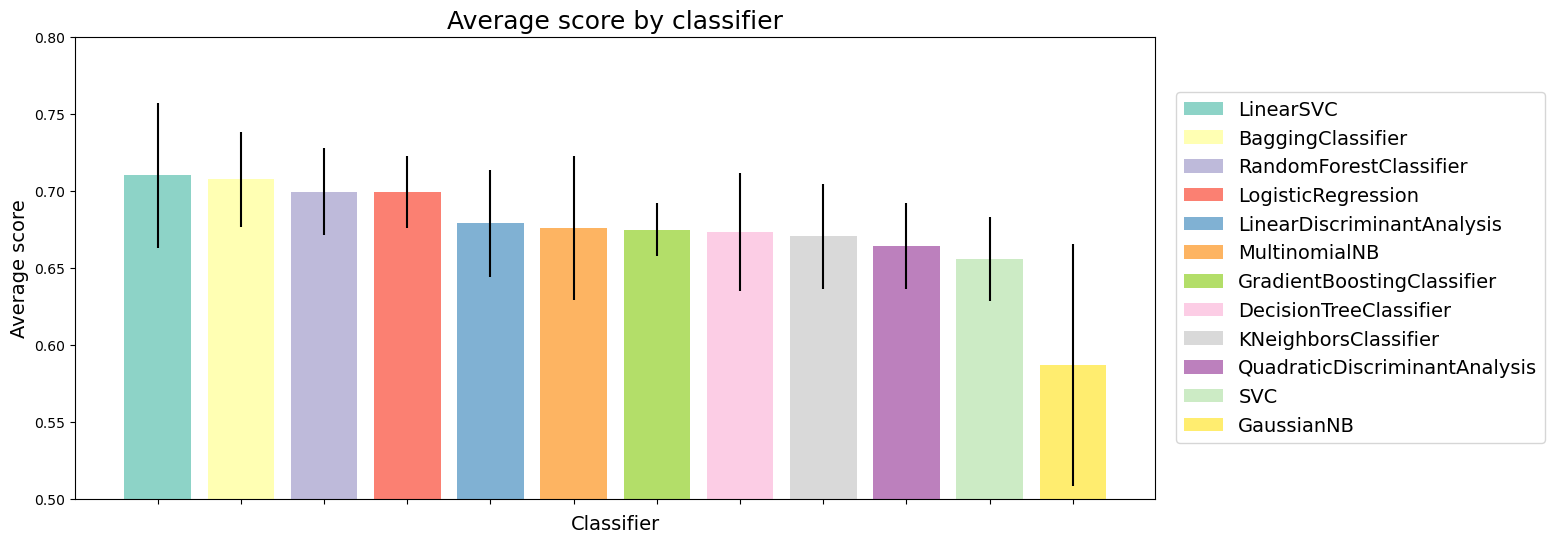

In [72]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(16,6))

colors = [mpl.colormaps['Set3'](i) for i in range(12)]
bars = ax.bar(models_summary_df['Classifier'], models_summary_df['Average score'], yerr=models_summary_df['Average std'], color=colors)
ax.set_xticklabels([])
ax.set_ylim(0.5, 0.8)
ax.set_title('Average score by classifier', fontsize="18")
ax.set_xlabel('Classifier', fontsize="14")
ax.set_ylabel('Average score', fontsize="14")
ax.legend(bars, models_summary_df['Classifier'], bbox_to_anchor = (1.37, 0.5), loc='center right', fontsize="14")

fig.subplots_adjust(right=0.8)

plt.show()

### Choosing final model
As we see 4 classifiers have notably better scores than the others - Linear SVC and BaggingClassifier with about 71% and RandomForestClassifier and LogisticRegression with about 70% of f1_micro average score.
Out of these 4 we choose RandomForestClassifier because it has the best 'best score' and second the best 'average std'.

In [65]:
horse_colic_classifier = model8.best_estimator_

Once we have chosen the final classifier then we will get more familiar with it.

In [66]:
features_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": horse_colic_classifier.feature_importances_})
features_importance_df = features_importance_df.sort_values('Importance', ascending=False)
features_importance_df

,Feature,Importance
47,total protein,0.096260
46,packed cell volume,0.091343
44,pulse,0.084533
43,rectal temperature,0.063393
45,respiratory rate,0.047700
48,mucous membranes,0.047183
11,lesion type -> strangulation,0.038639
52,abdominal distension,0.037180
19,lesion specific code -> volvulus/torsion,0.036397
55,number of lesions,0.026675


Now we will group OneHotEncoder variables into original ones. Importance of grouped features will be a max value of them.

In [67]:
dummies = ['lesion site', 'lesion type', 'lesion subtype', 'lesion specific code', 'pain',
                  'peristalsis', 'rectal examination - feces', 'abdomen']

for dummy in dummies:
    dummy_df = features_importance_df[features_importance_df['Feature'].str.startswith(dummy + " ->")]
    if dummy_df.empty:
        break
    row_to_add = pd.DataFrame({"Feature": dummy, "Importance": dummy_df["Importance"].max()}, index=[0])
    features_importance_df = pd.concat([features_importance_df, row_to_add], ignore_index=True)
    features_importance_df = features_importance_df.drop(features_importance_df[features_importance_df['Feature'].str.startswith(dummy + " ->")].index)

features_importance_df = features_importance_df.sort_values('Importance', ascending=False)
features_importance_df

,Feature,Importance
0,total protein,0.096260
1,packed cell volume,0.091343
2,pulse,0.084533
3,rectal temperature,0.063393
4,respiratory rate,0.047700
5,mucous membranes,0.047183
19,lesion type,0.038639
6,abdominal distension,0.037180
21,lesion specific code,0.036397
7,number of lesions,0.026675


And now we will plot a bar to visualize table above

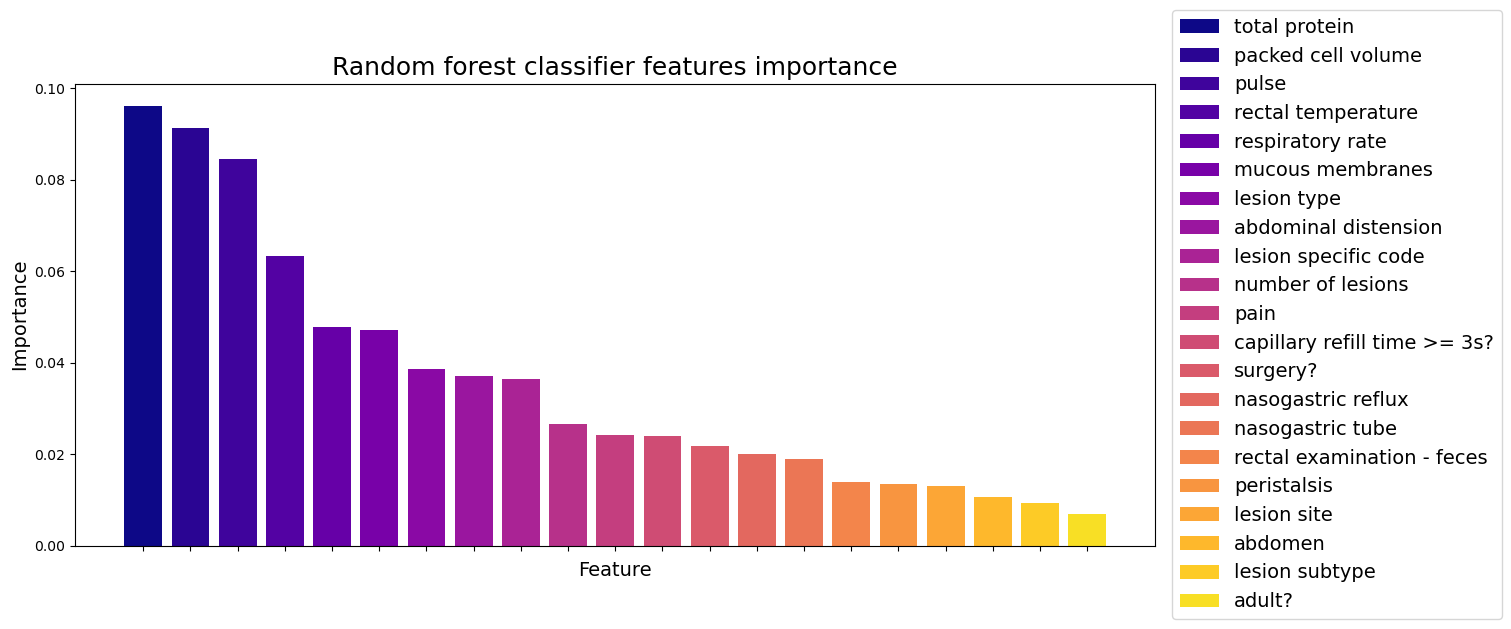

In [74]:
fig, ax = plt.subplots(figsize=(16,6))

cm = plt.get_cmap('plasma')
colors = [cm(12*i) for i in range(21)]
bars = ax.bar(features_importance_df['Feature'], features_importance_df['Importance'], color=colors)
ax.set_xticklabels([])
ax.set_title('Random forest classifier features importance', fontsize="18")
ax.set_xlabel('Feature', fontsize="14")
ax.set_ylabel('Importance', fontsize="14")
ax.legend(bars, features_importance_df['Feature'], bbox_to_anchor = (1.33, 0.5), loc='center right', fontsize="14")

fig.subplots_adjust(right=0.8)

plt.show()

## Evaluation
Now we will evaluate our model with a test data.

In [75]:
horse_colic_test_processed = dataTransformationPipe.transform(horse_colic_test)
horse_colic_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67 entries, 0 to 67
Data columns (total 57 columns):
 #   Column                                               Non-Null Count  Dtype   
---  ------                                               --------------  -----   
 0   lesion site -> gastric                               67 non-null     float64 
 1   lesion site -> sm intestine                          67 non-null     float64 
 2   lesion site -> lg colo                               67 non-null     float64 
 3   lesion site -> lg colon and cecum                    67 non-null     float64 
 4   lesion site -> cecum                                 67 non-null     float64 
 5   lesion site -> transverse colon                      67 non-null     float64 
 6   lesion site -> retum/descending colon                67 non-null     float64 
 7   lesion site -> uterus                                67 non-null     float64 
 8   lesion site -> bladder                               67 non-nu

In [76]:
X_test, y_test = horse_colic_test_processed.drop('outcome', axis=1), horse_colic_test_processed['outcome']
y_pred = horse_colic_classifier.predict(X_test)

The final score and confusion matrix is showed below

In [77]:
from sklearn.metrics import f1_score, confusion_matrix

confusion_m = confusion_matrix(y_test, y_pred)
print(f"Confusion matrix:\n{confusion_m}")
print(f"F1-micro score: {round(f1_score(y_test, y_pred, average='micro'), DECIMAL_PLACES)}")

Confusion matrix:
[[ 9  3  0]
 [ 5 40  2]
 [ 1  4  3]]
F1-micro score: 0.7761


In conclusion lets print out some statistics and visualize a confusion matrix on the plot.

In [78]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

          died       0.60      0.75      0.67        12
         lived       0.85      0.85      0.85        47
was euthanized       0.60      0.38      0.46         8

      accuracy                           0.78        67
     macro avg       0.68      0.66      0.66        67
  weighted avg       0.78      0.78      0.77        67



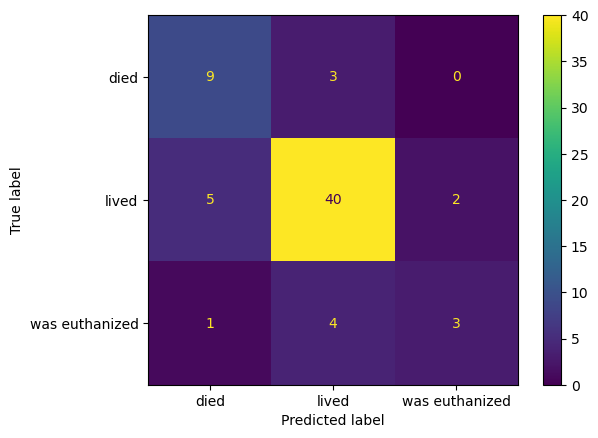

In [79]:
from sklearn.metrics import ConfusionMatrixDisplay

confusion_m_display = ConfusionMatrixDisplay(confusion_matrix = confusion_m, display_labels=['died', 'lived', 'was euthanized']).plot()

plt.show()

## Extras - binary prediction (died/survived)

In [80]:
class BinaryOutcomeTransformer:
    def transform(self,X,y=None):
        X["outcome"] = X["outcome"].replace("was euthanized", "died")
        return X

    def fit(self, X, y=None):
        return self

dataTransformationBinaryPipe = Pipeline([
    ('3_class_pipe', dataTransformationPipe),
    ('binary', BinaryOutcomeTransformer())
])

horse_colic_train_binary = dataTransformationBinaryPipe.fit_transform(horse_colic_train)
horse_colic_train_binary["outcome"].value_counts()

lived    178
died     121
Name: outcome, dtype: int64

In [81]:
from sklearn.base import clone


X_train_binary, y_train_binary = horse_colic_train_binary.drop('outcome', axis=1), horse_colic_train_binary['outcome']

horse_colic_classifier_binary = clone(horse_colic_classifier)
horse_colic_classifier_binary.fit(X_train_binary, y_train_binary)

RandomForestClassifier(ccp_alpha=0.002210917811940833, random_state=42)

In [82]:
horse_colic_test_binary = dataTransformationBinaryPipe.transform(horse_colic_test)

X_test_binary, y_test_binary = horse_colic_test_binary.drop('outcome', axis=1), horse_colic_test_binary['outcome']

y_pred_binary = horse_colic_classifier_binary.predict(X_test_binary)

In [83]:
confusion_m_binary = confusion_matrix(y_test_binary, y_pred_binary)
print(f"Confusion matrix:\n{confusion_m_binary}")
print(f"F1 score: {round(f1_score(y_test_binary, y_pred_binary, average='micro'), DECIMAL_PLACES)}")

Confusion matrix:
[[17  3]
 [10 37]]
F1 score: 0.806


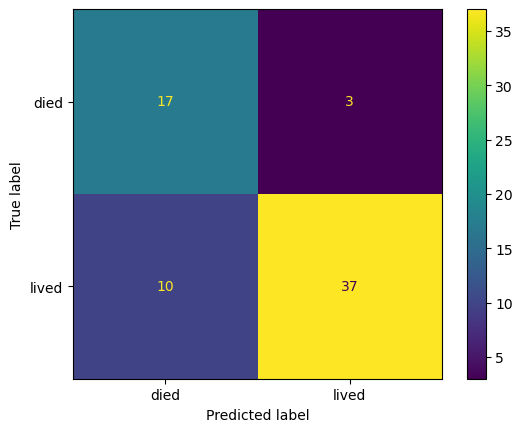

In [84]:
confusion_m_binary_display = ConfusionMatrixDisplay(confusion_matrix = confusion_m_binary, display_labels=['died', 'lived']).plot()

plt.show()